<a href="https://colab.research.google.com/github/marreapato/Forecasting_Paper_XAI/blob/main/classification_lime/Trying_Models_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Multivariate Stocks Baseline

## Libraries & Packages

In [1]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=16aacfb7c62388c15f88de7cfac930e049fe582c2aa88d4cc65201e709a32afa
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Flatten, Reshape, Bidirectional, Dropout

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
#from tensorflow.compat.v1.keras.backend import get_session

tf.compat.v1.disable_v2_behavior() # caracteristica necessaria para o uso shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
Instructions for updating:
non-resource variables are not supported in the long term


## Preprocessing

### Making the data

In [3]:
# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200
2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800
2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000
2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000
2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100
...,...,...,...,...,...,...
2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400
2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500
2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800


In [4]:
# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X', start='2007-01-01', end='2023-10-20')

# Display the first few rows of the downloaded data
exchange_rate_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-01,2.1310,2.1325,2.1310,2.1325,2.1325,0
2007-01-02,2.1335,2.1432,2.1295,2.1310,2.1310,0
2007-01-03,2.1310,2.1351,2.1278,2.1345,2.1345,0
2007-01-04,2.1345,2.1430,2.1345,2.1390,2.1390,0
2007-01-05,2.1390,2.1525,2.1345,2.1470,2.1470,0


In [5]:
exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})
exchange_rate_data.head(10)

,Date,USD
0,2007-01-01,2.1325
1,2007-01-02,2.1310
2,2007-01-03,2.1345
3,2007-01-04,2.1390
4,2007-01-05,2.1470
5,2007-01-08,2.1465
6,2007-01-09,2.1490
7,2007-01-10,2.1496
8,2007-01-11,2.1415
9,2007-01-12,2.1370


In [6]:
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
feriados

,Date,4_observance,4_optional,4_public
0,2007-01-01,0,0,1
1,2007-01-02,0,0,1
2,2007-02-17,0,1,0
3,2007-02-18,0,1,0
4,2007-02-19,0,1,0
...,...,...,...,...
697,2024-12-25,0,1,0
698,2024-12-25,0,0,1
699,2024-12-26,0,0,1
700,2024-12-31,0,1,0


In [7]:
data.reset_index(inplace=True)


In [8]:
feriados['Date']=feriados.Date.astype('datetime64[ns]')

In [9]:
data=data.merge(feriados, on='Date', how='left')

In [10]:
data['4_observance'] = data['4_observance'].fillna(0)
data['4_public'] = data['4_public'].fillna(0)
data['4_optional'] = data['4_optional'].fillna(0)

In [11]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0


In [12]:
data=data.merge(exchange_rate_data, on='Date', how='left')

In [13]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public,USD
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0,2.1310
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0,2.1345
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0,2.1390
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0,2.1470
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0,2.1465
...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400,0.0,0.0,0.0,5.1457
4153,2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500,0.0,0.0,0.0,5.1352
4154,2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800,0.0,0.0,0.0,5.0510
4155,2023-10-13,117050.0,117070.0,115658.0,115754.0,115754.0,10609300,0.0,0.0,1.0,5.0459


In [14]:
data['variation_low_high'] = ((data['High']-data['Low'])/data['Low'])*100

In [15]:
data = data.drop('Adj Close',axis = 1)
data = data.drop('Open',axis = 1)
data = data.drop('High',axis = 1)
data = data.drop('Low',axis = 1)
data = data.drop('Volume',axis = 1)

In [16]:
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)
selic

,Date,selic
0,24/01/2007,1
1,07/03/2007,1
2,18/04/2007,1
3,06/06/2007,1
4,18/07/2007,1
...,...,...
131,21/06/2023,1
132,02/08/2023,1
133,20/09/2023,1
134,01/11/2023,1


In [17]:
selic['Date'] = pd.to_datetime(selic['Date'])

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.


In [18]:
data=data.merge(selic, on='Date', how='left')
data['selic'] = data['selic'].fillna(0)
data.head()#SELIC WAS ADDED HERE

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.050544,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.472676,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.877450,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.556452,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.855543,0.0


In [19]:
selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

0      2007-01-24
1      2007-07-03
2      2007-04-18
3      2007-06-06
4      2007-07-18
          ...    
131    2023-06-21
132    2023-02-08
133    2023-09-20
134    2023-01-11
135    2023-12-13
Name: Date, Length: 136, dtype: object

### Binarizing the data

- The "Close" column has been transformed to binary taking into account its growth or decrease from the previous day.

In [20]:
def binarize_column(df, column_name):
    """
    Binarizes a column in a Pandas DataFrame, indicating 1 for increase compared to the previous value
    and 0 for decrease compared to the previous value.
    """

    # Calculate the difference between the column values and their previous values
    diff = df[column_name].diff()

    # Binarize the column based on the difference
    df['binarized_' + column_name] = (diff > 0).astype(int)



In [21]:
binarize_column(data, "Close")

In [22]:
data.columns

Index(['Date', 'Close', '4_observance', '4_optional', '4_public', 'USD',
       'variation_low_high', 'selic', 'binarized_Close'],
      dtype='object')

In [23]:
binary_data = data

In [24]:
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4157 entries, 0 to 4156
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                4157 non-null   datetime64[ns]
 1   Close               4157 non-null   float64       
 2   4_observance        4157 non-null   float64       
 3   4_optional          4157 non-null   float64       
 4   4_public            4157 non-null   float64       
 5   USD                 4126 non-null   float64       
 6   variation_low_high  4157 non-null   float64       
 7   selic               4157 non-null   float64       
 8   binarized_Close     4157 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 324.8 KB


In [25]:
binary_data['binarized_Close'] = binary_data['binarized_Close'].astype('float64')

In [26]:
binary_data.isnull().count()

Date                  4157
Close                 4157
4_observance          4157
4_optional            4157
4_public              4157
USD                   4157
variation_low_high    4157
selic                 4157
binarized_Close       4157
dtype: int64

### Lagged Data for XAI Comparison

In [27]:
def create_lagged_dataframe(data, lags, include_lag0=False,column_name='Close'):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data[column_name]

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}{column_name}'] = lagged_data[column_name].shift(lag)

    return lagged_data


In [28]:
# Create lag features for the entire dataset
include_lag0 = False  # You can set this to True if you want to include lag0
look_back = 6
lagged_data = create_lagged_dataframe(binary_data, look_back, include_lag0, 'Close')
lagged_data = create_lagged_dataframe(lagged_data, look_back, include_lag0,column_name = 'USD')
lagged_data = create_lagged_dataframe(lagged_data, look_back, include_lag0,column_name = 'variation_low_high')


In [29]:
lagged_data = lagged_data.dropna()  # Drop rows with NaN values

In [30]:
lagged_data= lagged_data.drop(columns=['Close','USD', 'variation_low_high'])

In [31]:
lagged_data

,Date,4_observance,4_optional,4_public,selic,binarized_Close,lag1Close,lag2Close,lag3Close,lag4Close,...,lag3USD,lag4USD,lag5USD,lag6USD,lag1variation_low_high,lag2variation_low_high,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high
6,2007-01-10,0.0,0.0,0.0,0.0,1.0,42007.0,42830.0,42245.0,44020.0,...,2.1470,2.1390,2.1345,2.1310,3.771900,1.855543,4.556452,1.877450,2.472676,2.050544
7,2007-01-11,0.0,0.0,0.0,0.0,1.0,42336.0,42007.0,42830.0,42245.0,...,2.1465,2.1470,2.1390,2.1345,2.592934,3.771900,1.855543,4.556452,1.877450,2.472676
8,2007-01-12,0.0,0.0,0.0,0.0,1.0,42670.0,42336.0,42007.0,42830.0,...,2.1490,2.1465,2.1470,2.1390,2.832618,2.592934,3.771900,1.855543,4.556452,1.877450
9,2007-01-15,0.0,0.0,0.0,0.0,0.0,43095.0,42670.0,42336.0,42007.0,...,2.1496,2.1490,2.1465,2.1470,1.556695,2.832618,2.592934,3.771900,1.855543,4.556452
10,2007-01-16,0.0,0.0,0.0,0.0,0.0,42919.0,43095.0,42670.0,42336.0,...,2.1415,2.1496,2.1490,2.1465,1.394752,1.556695,2.832618,2.592934,3.771900,1.855543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,0.0,0.0,0.0,0.0,1.0,114170.0,113284.0,113607.0,113419.0,...,5.1663,5.0615,5.0428,5.0328,2.591421,1.467548,0.919176,1.683591,1.665200,0.999637
4153,2023-10-10,0.0,0.0,0.0,0.0,1.0,115156.0,114170.0,113284.0,113607.0,...,5.1546,5.1663,5.0615,5.0428,1.561068,2.591421,1.467548,0.919176,1.683591,1.665200
4154,2023-10-11,0.0,0.0,0.0,0.0,1.0,116737.0,115156.0,114170.0,113284.0,...,5.1650,5.1546,5.1663,5.0615,1.512704,1.561068,2.591421,1.467548,0.919176,1.683591
4155,2023-10-13,0.0,0.0,1.0,0.0,0.0,117051.0,116737.0,115156.0,114170.0,...,5.1457,5.1650,5.1546,5.1663,0.746789,1.512704,1.561068,2.591421,1.467548,0.919176


### Separating into training and testing

In [32]:
train_size = int(len(lagged_data) * 0.8)
test_size = len(lagged_data) - train_size

print('Total size: ', len(lagged_data))
print("Train size: ", train_size)
print("Test size: ", test_size)

Total size:  4033
Train size:  3226
Test size:  807


In [33]:
train, test = lagged_data[0:train_size], lagged_data[train_size:len(binary_data)]

In [34]:
lagged_data.columns

Index(['Date', '4_observance', '4_optional', '4_public', 'selic',
       'binarized_Close', 'lag1Close', 'lag2Close', 'lag3Close', 'lag4Close',
       'lag5Close', 'lag6Close', 'lag1USD', 'lag2USD', 'lag3USD', 'lag4USD',
       'lag5USD', 'lag6USD', 'lag1variation_low_high',
       'lag2variation_low_high', 'lag3variation_low_high',
       'lag4variation_low_high', 'lag5variation_low_high',
       'lag6variation_low_high'],
      dtype='object')

In [35]:
test

,Date,4_observance,4_optional,4_public,selic,binarized_Close,lag1Close,lag2Close,lag3Close,lag4Close,...,lag3USD,lag4USD,lag5USD,lag6USD,lag1variation_low_high,lag2variation_low_high,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high
3350,2020-07-20,0.0,0.0,0.0,0.0,1.0,102888.0,100553.0,101791.0,100440.0,...,5.366800,5.401500,5.326900,5.337800,2.449430,1.629393,1.662618,2.383787,2.189530,1.379394
3351,2020-07-21,0.0,0.0,0.0,0.0,0.0,104426.0,102888.0,100553.0,101791.0,...,5.366948,5.366800,5.401500,5.326900,1.649731,2.449430,1.629393,1.662618,2.383787,2.189530
3352,2020-07-22,0.0,0.0,0.0,0.0,0.0,104310.0,104426.0,102888.0,100553.0,...,5.330700,5.366948,5.366800,5.401500,1.655227,1.649731,2.449430,1.629393,1.662618,2.383787
3353,2020-07-23,0.0,0.0,0.0,0.0,0.0,104290.0,104310.0,104426.0,102888.0,...,5.385300,5.330700,5.366948,5.366800,1.648963,1.655227,1.649731,2.449430,1.629393,1.662618
3354,2020-07-24,0.0,0.0,0.0,0.0,1.0,102293.0,104290.0,104310.0,104426.0,...,5.327700,5.385300,5.330700,5.366948,2.771277,1.648963,1.655227,1.649731,2.449430,1.629393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,0.0,0.0,0.0,0.0,1.0,114170.0,113284.0,113607.0,113419.0,...,5.166300,5.061500,5.042800,5.032800,2.591421,1.467548,0.919176,1.683591,1.665200,0.999637
4153,2023-10-10,0.0,0.0,0.0,0.0,1.0,115156.0,114170.0,113284.0,113607.0,...,5.154600,5.166300,5.061500,5.042800,1.561068,2.591421,1.467548,0.919176,1.683591,1.665200
4154,2023-10-11,0.0,0.0,0.0,0.0,1.0,116737.0,115156.0,114170.0,113284.0,...,5.165000,5.154600,5.166300,5.061500,1.512704,1.561068,2.591421,1.467548,0.919176,1.683591
4155,2023-10-13,0.0,0.0,1.0,0.0,0.0,117051.0,116737.0,115156.0,114170.0,...,5.145700,5.165000,5.154600,5.166300,0.746789,1.512704,1.561068,2.591421,1.467548,0.919176


In [36]:
trainX= train.drop(columns=['binarized_Close','Date']).values
testX = test.drop(columns=['binarized_Close','Date']).values
trainY= train['binarized_Close'].values
testY= test['binarized_Close'].values

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3226, 22)
TrainY shape: (3226,)
TestX shape: (807, 22)
TestY shape: (807,)


In [37]:
trainX = np.array(trainX)
testX = np.array(testX)

In [38]:
np.reshape(trainX, (1,-1)).shape

(1, 70972)

In [39]:
X_train = trainX
X_test = testX
y_train = trainY
y_test = testY

## Models

In [40]:
accs = []
models = ['Randon Forest', 'Naive Bayes', 'XGBoost', 'LSTM', 'BiLSTM', 'GRU']

### Randon Forest

In [41]:
def model_rf_classifier(X_train, y_train,X_test, y_test):
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    predctions = model.predict(X_test)

    acc= accuracy_score(y_test, predctions)
    c_matrix = confusion_matrix(y_test, predctions)
    report = classification_report(y_test, predctions)

    print(f"accuracy: {acc}")
    print(f"confusion matrix: \n{c_matrix}")
    print(f"classification report: \n{report}")

    return model

# Chame a função para treinar o modelo e imprimir as métricas
model_rf = model_rf_classifier(trainX,trainY,testX,testY)


accuracy: 0.5030978934324659
confusion matrix: 
[[272 124]
 [277 134]]
classification report: 
              precision    recall  f1-score   support

         0.0       0.50      0.69      0.58       396
         1.0       0.52      0.33      0.40       411

    accuracy                           0.50       807
   macro avg       0.51      0.51      0.49       807
weighted avg       0.51      0.50      0.49       807



### Naive Bayes

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

def model_naive_bayes(X_train, y_train,X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    predctions = model.predict(X_test)

    acc= accuracy_score(y_test, predctions)
    c_matrix = confusion_matrix(y_test, predctions)
    report = classification_report(y_test, predctions)

    print(f"accuracy: {acc}")
    print(f"confusion matrix: \n{c_matrix}")
    print(f"classification report: \n{report}")

    return model

model_nb = model_naive_bayes(trainX,trainY,testX,testY)


accuracy: 0.5092936802973977
confusion matrix: 
[[  0 396]
 [  0 411]]
classification report: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       396
         1.0       0.51      1.00      0.67       411

    accuracy                           0.51       807
   macro avg       0.25      0.50      0.34       807
weighted avg       0.26      0.51      0.34       807



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### XGBoost

In [61]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def xgboost_time_series_classification(X_train,y_train,X_test,y_test):
    model = XGBClassifier(learning_rate =0.001, n_estimators=1000, gamma=0.2,seed=2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return model

model_xgb = xgboost_time_series_classification(trainX,trainY,testX,testY)

Accuracy: 0.5278810408921933
Precision: 0.5283018867924528
Recall: 0.681265206812652
F1 Score: 0.5951115834218916


In [62]:
columns = lagged_data.drop(columns=['binarized_Close','Date']).columns

feature_importance = model_xgb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature':columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)


Feature Importance:
                   Feature  Importance
13                 lag4USD    0.075381
3                    selic    0.068333
9                lag6Close    0.065750
12                 lag3USD    0.060968
2                 4_public    0.058960
7                lag4Close    0.057212
6                lag3Close    0.056464
20  lag5variation_low_high    0.052869
21  lag6variation_low_high    0.049109
15                 lag6USD    0.048944
14                 lag5USD    0.048339
16  lag1variation_low_high    0.046607
19  lag4variation_low_high    0.043693
17  lag2variation_low_high    0.043611
11                 lag2USD    0.042008
8                lag5Close    0.040266
4                lag1Close    0.039823
18  lag3variation_low_high    0.035618
10                 lag1USD    0.033603
5                lag2Close    0.032443
0             4_observance    0.000000
1               4_optional    0.000000


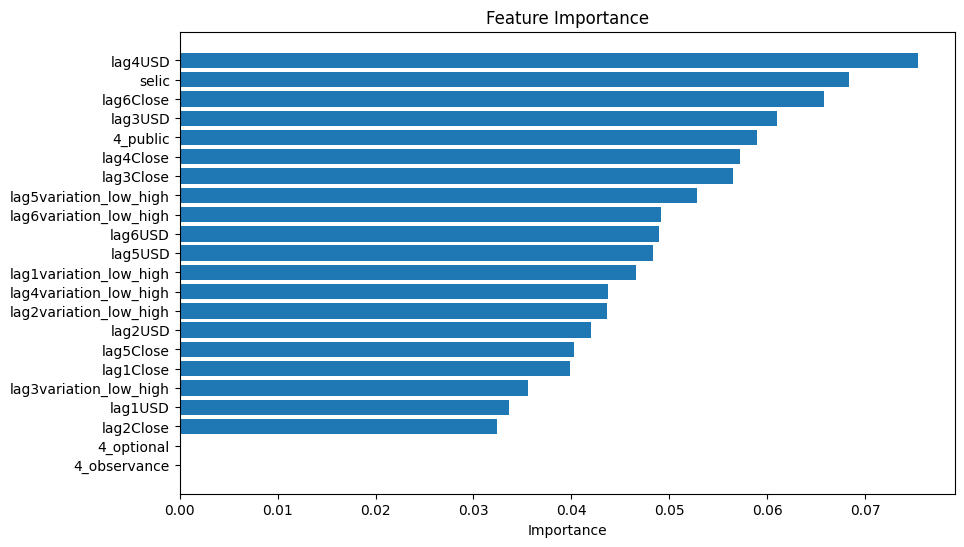

In [63]:
plt.figure(figsize=(10, 6))
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

### LSTM

In [64]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Reshape

def LSTM_Model(input_shape, output_window):
    model = Sequential([
        Reshape((1,-1)),
        LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True),
        #Dropout(0.2),
        #Flatten(),
        Dense(output_window, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

output_window = 1

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1]))
testX = testX.reshape((testX.shape[0], testX.shape[1]))

input_shape = (trainX.shape[0], trainX.shape[1])
lstm_model = LSTM_Model(input_shape, output_window)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



history = lstm_model.fit(trainX, trainY, epochs=300, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_accuracy = lstm_model.evaluate(testX, testY)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Train on 2580 samples, validate on 646 samples
Epoch 1/300
2580/2580 [==============================] - 2s 661us/sample - loss: 73.5277 - acc: 0.4952 - val_loss: 28.5867 - val_acc: 0.5215
Epoch 2/300
1088/2580 [===========>..................] - ETA: 0s - loss: 13.8498 - acc: 0.4981

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


2580/2580 [==============================] - 0s 63us/sample - loss: 16.0753 - acc: 0.4996 - val_loss: 60.0005 - val_acc: 0.5336
Epoch 3/300
2580/2580 [==============================] - 0s 69us/sample - loss: 16.8098 - acc: 0.4951 - val_loss: 31.1832 - val_acc: 0.5315
Epoch 4/300
2580/2580 [==============================] - 0s 67us/sample - loss: 39.4482 - acc: 0.4852 - val_loss: 87.0028 - val_acc: 0.5341
Epoch 5/300
2580/2580 [==============================] - 0s 88us/sample - loss: 25.2353 - acc: 0.4990 - val_loss: 65.9874 - val_acc: 0.5339
Epoch 6/300
2580/2580 [==============================] - 0s 95us/sample - loss: 23.2499 - acc: 0.5069 - val_loss: 19.6592 - val_acc: 0.4780
Epoch 7/300
2580/2580 [==============================] - 0s 99us/sample - loss: 20.5281 - acc: 0.5095 - val_loss: 39.8353 - val_acc: 0.4704
Epoch 8/300
2580/2580 [==============================] - 0s 97us/sample - loss: 52.1599 - acc: 0.5073 - val_loss: 14.9902 - val_acc: 0.4924
Epoch 9/300
2580/2580 [=========

In [65]:
# testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

loss, accuracy = lstm_model.evaluate(testX, testY)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 9.44972480835377
Test Accuracy: 0.49970758


In [66]:
predicted = lstm_model.predict(testX)
# Define a threshold
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
predicted = (predicted >= threshold).astype(int)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [67]:

print(classification_report(testY,predicted.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.45      0.16      0.23       396
         1.0       0.50      0.81      0.62       411

    accuracy                           0.49       807
   macro avg       0.47      0.48      0.43       807
weighted avg       0.47      0.49      0.43       807



### Bidirectional LSTM

In [68]:
def biLSTM_Model(input_shape, output_window):
    model = Sequential([
        Reshape((1,-1)),
        Bidirectional(LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True)),
       # Dropout(0.2),
        Flatten(),
        Dense(output_window, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

output_window = 1
#input_shape = (trainX.shape[1], 1)
bilstm_model = biLSTM_Model(input_shape, output_window)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

##trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
#testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

history = bilstm_model.fit(trainX, trainY, epochs=300, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 2580 samples, validate on 646 samples
Epoch 1/300
2580/2580 [==============================] - 1s 220us/sample - loss: 155.1852 - acc: 0.5078 - val_loss: 51.3752 - val_acc: 0.4644
Epoch 2/300
 960/2580 [==========>...................] - ETA: 0s - loss: 25.1012 - acc: 0.5312

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


2580/2580 [==============================] - 0s 72us/sample - loss: 22.3604 - acc: 0.5112 - val_loss: 26.5990 - val_acc: 0.5418
Epoch 3/300
2580/2580 [==============================] - 0s 69us/sample - loss: 29.8705 - acc: 0.4891 - val_loss: 78.9788 - val_acc: 0.5279
Epoch 4/300
2580/2580 [==============================] - 0s 79us/sample - loss: 29.1942 - acc: 0.5116 - val_loss: 28.3466 - val_acc: 0.5186
Epoch 5/300
2580/2580 [==============================] - 0s 66us/sample - loss: 24.0030 - acc: 0.4996 - val_loss: 117.2147 - val_acc: 0.4690
Epoch 6/300
2580/2580 [==============================] - 0s 66us/sample - loss: 51.3630 - acc: 0.5000 - val_loss: 105.7304 - val_acc: 0.4690
Epoch 7/300
2580/2580 [==============================] - 0s 68us/sample - loss: 46.4155 - acc: 0.4953 - val_loss: 22.0830 - val_acc: 0.5356
Epoch 8/300
2580/2580 [==============================] - 0s 71us/sample - loss: 30.5447 - acc: 0.4926 - val_loss: 28.8520 - val_acc: 0.5186
Epoch 9/300
2580/2580 [=======

In [69]:
# testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

loss, accuracy = bilstm_model.evaluate(testX, testY)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 24.74611238151087
Test Accuracy: 0.4795539


In [70]:
predicted = bilstm_model.predict(testX)
# Define a threshold
threshold = 0.5
predicted=np.argmax(predicted,axis=1)
# Convert probabilities to binary predictions based on the threshold
#predicted = (predicted >= threshold).astype(int)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [71]:

print(classification_report(testY,predicted.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       396
         1.0       0.00      0.00      0.00       411

    accuracy                           0.49       807
   macro avg       0.25      0.50      0.33       807
weighted avg       0.24      0.49      0.32       807



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### GRU

In [72]:
from tensorflow.keras.callbacks import EarlyStopping

def GRU_Model(input_shape, output_window):
    model = Sequential([
        Reshape((1,-1)),
        GRU(128, activation='relu', input_shape=input_shape, return_sequences=True),
        #Dropout(0.2),
       #Flatten(),
        Dense(output_window, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

output_window = 1
#input_shape = (trainX.shape[1], 1)
gru_model = GRU_Model(input_shape, output_window)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
#testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

history = gru_model.fit(trainX, trainY, epochs=300, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_accuracy = gru_model.evaluate(testX, testY)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Train on 2580 samples, validate on 646 samples
Epoch 1/300
2580/2580 [==============================] - 0s 187us/sample - loss: 125.6575 - acc: 0.5005 - val_loss: 67.3366 - val_acc: 0.5092
Epoch 2/300
  64/2580 [..............................] - ETA: 0s - loss: 40.6443 - acc: 0.4839

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


2580/2580 [==============================] - 0s 68us/sample - loss: 51.0852 - acc: 0.5017 - val_loss: 87.3294 - val_acc: 0.4766
Epoch 3/300
2580/2580 [==============================] - 0s 70us/sample - loss: 44.2240 - acc: 0.5070 - val_loss: 68.8273 - val_acc: 0.5210
Epoch 4/300
2580/2580 [==============================] - 0s 66us/sample - loss: 54.8779 - acc: 0.4967 - val_loss: 58.2465 - val_acc: 0.5128
Epoch 5/300
2580/2580 [==============================] - 0s 64us/sample - loss: 39.1098 - acc: 0.5014 - val_loss: 52.1635 - val_acc: 0.4940
Epoch 6/300
2580/2580 [==============================] - 0s 68us/sample - loss: 39.5232 - acc: 0.4998 - val_loss: 78.4363 - val_acc: 0.4773
Epoch 7/300
2580/2580 [==============================] - 0s 64us/sample - loss: 45.2792 - acc: 0.4977 - val_loss: 117.5954 - val_acc: 0.4672
Epoch 8/300
2580/2580 [==============================] - 0s 61us/sample - loss: 37.8063 - acc: 0.4932 - val_loss: 44.2810 - val_acc: 0.4927
Epoch 9/300
2580/2580 [========

In [73]:
# testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

loss, accuracy = gru_model.evaluate(testX, testY)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 15.370657972834515
Test Accuracy: 0.51109207


In [74]:
predicted = gru_model.predict(testX)
# Define a threshold
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
predicted = (predicted >= threshold).astype(int)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [75]:

print(classification_report(testY,predicted.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40       396
         1.0       0.51      0.67      0.58       411

    accuracy                           0.51       807
   macro avg       0.50      0.50      0.49       807
weighted avg       0.50      0.51      0.49       807



Explanations

In [76]:
sample_train = trainX.copy()
gru_explainer = shap.Explainer(model_xgb, sample_train) # Substitua 10 pelo número desejado de exemplos para a baseline


In [77]:
# Calcular os valores SHAP
sample = testX.copy()

In [78]:
shap_values = gru_explainer.shap_values(sample)

 99%|===================| 799/807 [00:18<00:00]       

In [79]:
print(shap_values[0].shape)
shap_values[0]

(22,)


array([ 0.00000000e+00,  0.00000000e+00, -9.53479405e-04,  9.44947492e-05,
       -2.18701194e-02,  5.39158384e-05,  1.05048297e-02,  1.72063958e-02,
       -5.40641413e-04, -3.54836710e-03, -5.21342423e-04, -1.22397914e-02,
       -2.33579819e-02, -2.36720090e-03,  1.11857115e-01,  3.87444555e-03,
        1.50990799e-02,  3.56049350e-03, -1.53832617e-02,  2.06922769e-04,
       -1.01915645e-02,  1.00870573e-02])

In [80]:
columnnames = lagged_data.columns[1:].values
columnnames = np.delete(columnnames, 4)
columnnames

array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1USD', 'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high'], dtype=object)

In [81]:
np.array(shap_values)[0].shape

(22,)

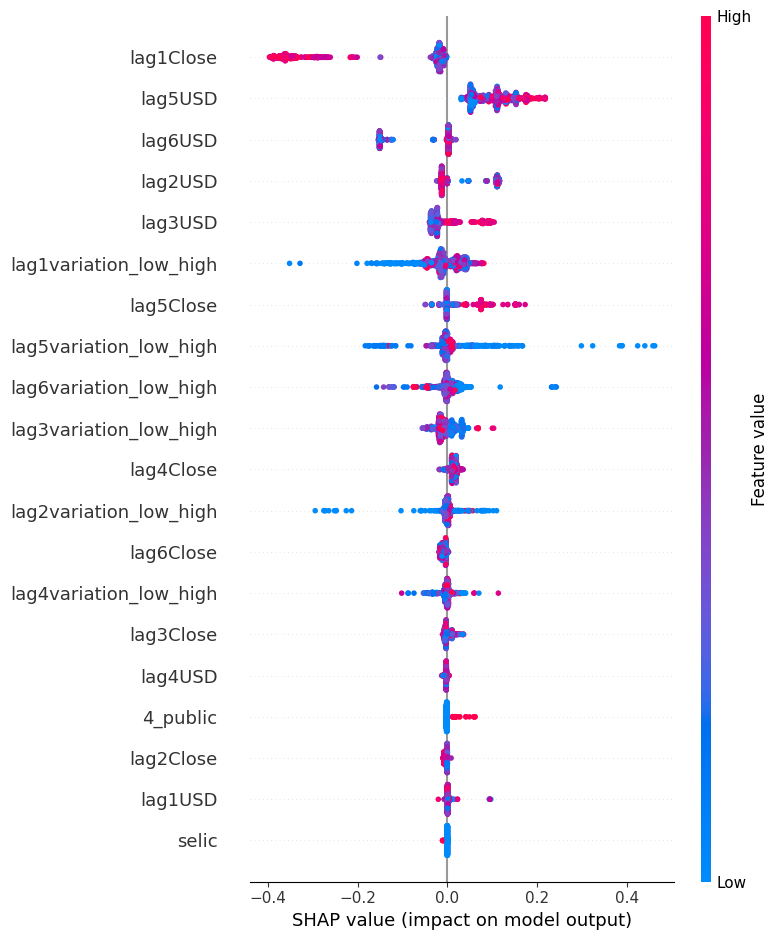

In [82]:
shap.summary_plot(np.array(shap_values), sample, feature_names=columnnames )

# Validação Lime

In [83]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
# Set a seed for reproducibility
np.random.seed(42)
# Criando um explainer do Lime
explainer = LimeTabularExplainer(X_train,
                                 mode="classification",
                                 feature_names=columnnames,
                                 training_labels=y_train,
                                 categorical_features=[[0,1,2,3]],
                                 discretize_continuous=True)

In [84]:
#values 1
sample_idx = np.random.choice(range(len(X_test)), size=(1,))[0]#830
print(sample_idx)
np.random.seed(42)
X_sample = testX[sample_idx]#testXnsc[sample_idx]



102


In [85]:
X_sample.shape

(22,)

In [86]:
model_xgb.predict_proba(X_test)

array([[0.4600746 , 0.5399254 ],
       [0.44410145, 0.55589855],
       [0.45602167, 0.54397833],
       ...,
       [0.56480706, 0.4351929 ],
       [0.558041  , 0.441959  ],
       [0.57065773, 0.42934227]], dtype=float32)

In [87]:
#values 1
sample_idx = np.random.choice(range(len(X_test)), size=(1,))[0]#830
print(sample_idx)
np.random.seed(42)
X_sample = testX[sample_idx]#testXnsc[sample_idx]



102


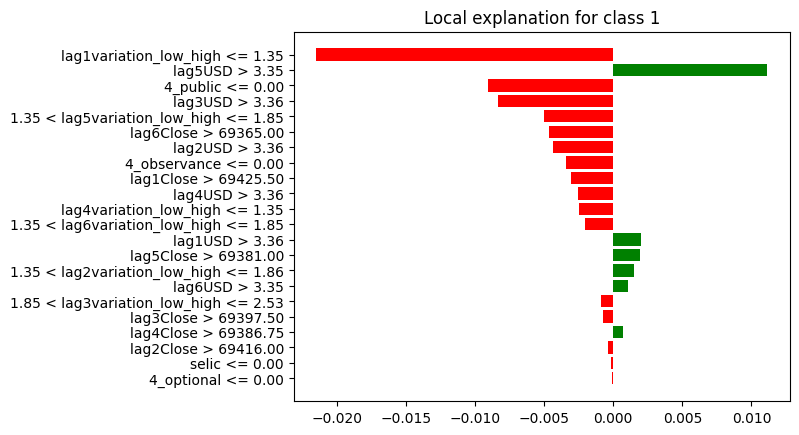

In [88]:
# Explicação do modelo usando o explainer do Lime
explanation1 = explainer.explain_instance(X_sample,
                                         model_xgb.predict_proba,
                                         num_features=(22))

# Visualizando a explicação
fig = explanation1.as_pyplot_figure()
plt.show()

In [89]:
scaler.inverse_transform(np.array([0.09,0.44,0,0,0,0,0.42]).reshape(1,-1))[0][0]

NameError: name 'scaler' is not defined

In [90]:
order_standardize

NameError: name 'order_standardize' is not defined